In [1]:
%matplotlib inline

In [2]:
import sys
import random
sys.path.append("../")
from ds4400_final_project.dataset.load_gtzan import load_data_from_file
from ds4400_final_project.dataset.common import print_classifier_results
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

The following loads the dataset, as well as dictionaries mapping the genre and its integer encoding (to be used as the ground truths in training and testing the models).

In [3]:
# import the data from the 3 seconds and 30 seconds features CSV
X_3, y_3, index_genre_map_3, genre_index_map_3 = load_data_from_file("features_3_sec.csv")
X_30, y_30, index_genre_map_30, genre_index_map_30 = load_data_from_file("features_30_sec.csv")

The following splits our data into training and testing sets. The data is split 67%/33% between training and testing, and is randomly shuffled.

In [4]:
# split all the data into training, validation and testing sets
TEST_SIZE = 0.20
VAL_SIZE = 0.25
RANDOM_STATE = 42

torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=TEST_SIZE, random_state=RANDOM_STATE)
x_30_train, x_30_test, y_30_train, y_30_test = train_test_split(X_30, y_30, test_size=TEST_SIZE, random_state=RANDOM_STATE)
x_3_train, x_3_val, y_3_train, y_3_val = train_test_split(x_3_train, y_3_train, test_size=VAL_SIZE, random_state=RANDOM_STATE)
x_30_train, x_30_val, y_30_train, y_30_val = train_test_split(x_30_train, y_30_train, test_size=VAL_SIZE, random_state=RANDOM_STATE)

y_3_train, y_3_val, y_3_test, y_30_train, y_30_val, y_30_test = map(torch.LongTensor, [y_3_train, y_3_val, y_3_test, y_30_train, y_30_val, y_30_test])
x_3_train, x_3_val, x_3_test, x_30_train, x_30_val, x_30_test = map(torch.FloatTensor, [x_3_train, x_3_val, x_3_test, x_30_train, x_30_val, x_30_test])

The following blocks define the architectures of the MLP models used for these experiments. `ShallowModel` is a MLP with one hidden layer, while `DeepModelTwoHiddenLayer` and `DeepModelThreeHiddenLayer` define MLPs with two and three hidden layers, respectively.

In [5]:
class ShallowModel(nn.Module):

    def __init__(self, num_hidden: int):
        super().__init__()
        self.hidden = nn.Linear(57, num_hidden)
        self.output = nn.Linear(num_hidden, 10)
        

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

In [6]:
class DeepModelTwoHiddenLayer(nn.Module):

    def __init__(self, num_hidden_nodes_1: int, num_hidden_nodes_2: int):
        super().__init__()
        self.hidden1 = nn.Linear(57, num_hidden_nodes_1)
        self.hidden2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.output = nn.Linear(num_hidden_nodes_2, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

class DeepModelThreeHiddenLayer(nn.Module):

    def __init__(self, num_hidden_nodes_1: int, num_hidden_nodes_2: int, num_hidden_nodes_3: int):
        super().__init__()
        self.hidden1 = nn.Linear(57, num_hidden_nodes_1)
        self.hidden2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.hidden3 = nn.Linear(num_hidden_nodes_2, num_hidden_nodes_3)
        self.output = nn.Linear(num_hidden_nodes_3, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.output(x)
        return x

The following defines a PyTorch `Dataset` that enables us to use PyTorch's `DataLoader` class for batching.

In [7]:
class GTZANDataset(Dataset):

    def __init__(self, x_data, y_data):
        self._x_data = x_data
        self._y_data = y_data

    def __len__(self):
        return len(self._x_data)
        
    def __getitem__(self, idx):
        return [self._x_data[idx], self._y_data[idx]]

The following defines a function for training a model instance.

In [8]:
def train_model(model, loss_func, x_train, y_train, x_val, y_val, epochs: int, lr: float, batch_size: int, verbose = False):
	train_dataset = GTZANDataset(x_train, y_train)
	val_dataset = GTZANDataset(x_val, y_val)
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
	val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

	# set the model to training mode
	model.train()

	# save average losses every epoch
	losses = []

	# save average validation accuracy every epoch
	accuracies = []

	# optimize the model
	for epoch in range(epochs):

		optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

		losses_each_batch = []

		for _, (x, y) in enumerate(train_dataloader):

			y_pred = model(x)

			loss = loss_func(y_pred, y)

			# backpropogation
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# with torch.no_grad():
			# 	for param in model.parameters():
			# 		param -= lr * param.grad

			# save the loss for this batch
			losses_each_batch.append(loss.item())

		# average all the batch losses for this epoch and save it
		avg_loss_epoch = sum(losses_each_batch) / len(losses_each_batch)
		losses.append(avg_loss_epoch)

		if verbose and (epoch % 50 == 0):
			print(f"Epoch [{epoch:03}]: average loss: {avg_loss_epoch:>7f}")

		correct = 0
		pred = 0
		for _, (x, y) in enumerate(val_dataloader):
			with torch.no_grad():
				y_pred = model(x)

				y_pred_softmax = torch.log_softmax(y_pred, dim=1)
				_, y_pred_tags = torch.max(y_pred_softmax, dim=1)

				correct_pred = (y_pred_tags == y).float()
				correct += int(correct_pred.sum())
				pred += len(correct_pred)

		acc = correct / pred
		accuracies.append(acc)

		if verbose and (epoch % 50 == 0):
			print(f"Epoch [{epoch:03}]: average validation accuracy: {acc:>7f}")

	# set the model to evaluation mode
	model.eval()
	return model, losses, accuracies

The following function enables us to run multiple different experiments in a single function call. The experiments are configured using Python dictionaries defining:
* The model class
* Arguments for the model class's constructor
* The loss function class
* Arguments for the loss function class's constructor
* The number of epochs
* The learning rate
* The rate for L2 regularization
* The batch size
* A verbose option for printing the loss during training

In [9]:
def run_training_experiments(experiment_configs, x_train, y_train, x_val, y_val):

    models = {}

    for model_id, config in experiment_configs.items():
        model_class = config["model_class"]
        model_kwargs = config["model_kwargs"] if "model_kwargs" in config.keys() else {} 
        model_instance = model_class(**model_kwargs)
        loss_func_class = config["loss_func_class"]
        loss_func_kwargs = config["loss_func_kwargs"] if "loss_func_kwargs" in config.keys() else {}
        loss_func = loss_func_class(**loss_func_kwargs)

        print(f"TRAINING MODEL: {model_id}")

        output_model, losses, accuracies = train_model(
            model=model_instance,
            loss_func=loss_func,
            x_train=x_train,
            y_train=y_train,
            x_val=x_val,
            y_val=y_val,
            epochs=config["epoch"],
            lr=config["lr"],
            batch_size=config["batch_size"],
            verbose=config["verbose"]
        )

        models[model_id] = {"model": output_model, "losses": losses, "accuracies": accuracies}

    return models


The following code block runs multiple experiments on various learning rates. Our hyperparameter tuning attempts to search for the optimal learning rate and the optimal model architecture. This might take about 15 - 20 minutes

In [10]:
EPOCHS = 1000
BATCH_SIZE = 128

lr_experiment_dict_3_sec = {}
lr_experiment_dict_30_sec = {}

for lr in [0.1, 0.01, 0.001]:
    print(f"EVALUATING ON LEARNING RATE = {lr}")
    print("------------------------------------")
    experiments = {
        "1 Hidden Layer, 32 Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 32
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "1 Hidden Layer, 64 Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 64
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "1 Hidden Layer, 128 Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 128
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "2 Hidden Layers, 64 and 32 nodes": {
            "model_class": DeepModelTwoHiddenLayer,
            "model_kwargs": {
                "num_hidden_nodes_1": 64,
                "num_hidden_nodes_2": 32
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "2 Hidden Layers, 128 and 64 nodes": {
            "model_class": DeepModelTwoHiddenLayer,
            "model_kwargs": {
                "num_hidden_nodes_1": 128,
                "num_hidden_nodes_2": 64
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "3 Hidden Layers, 128, 64, and 32 Nodes": {
            "model_class": DeepModelThreeHiddenLayer,
            "model_kwargs": {
                "num_hidden_nodes_1": 128,
                "num_hidden_nodes_2": 64,
                "num_hidden_nodes_3": 32
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "batch_size": BATCH_SIZE,
            "verbose": True
        }
    }

    three_sec_training_results = run_training_experiments(experiment_configs=experiments, x_train=x_3_train, y_train=y_3_train, x_val=x_3_val, y_val=y_3_val)
    thirty_sec_training_results = run_training_experiments(experiment_configs=experiments, x_train=x_30_train, y_train=y_30_train, x_val=x_30_val, y_val=y_30_val)
    lr_experiment_dict_3_sec[str(lr)] = three_sec_training_results
    lr_experiment_dict_30_sec[str(lr)] = thirty_sec_training_results

EVALUATING ON LEARNING RATE = 0.1
------------------------------------
TRAINING MODEL: 1 Hidden Layer, 32 Nodes
Epoch [000]: average loss: 1.959663
Epoch [000]: average validation accuracy: 0.445445
Epoch [050]: average loss: 0.460976
Epoch [050]: average validation accuracy: 0.784785
Epoch [100]: average loss: 0.336033
Epoch [100]: average validation accuracy: 0.798298
Epoch [150]: average loss: 0.275497
Epoch [150]: average validation accuracy: 0.800300
Epoch [200]: average loss: 0.234329
Epoch [200]: average validation accuracy: 0.801301
Epoch [250]: average loss: 0.205638
Epoch [250]: average validation accuracy: 0.795796
Epoch [300]: average loss: 0.185478
Epoch [300]: average validation accuracy: 0.799299
Epoch [350]: average loss: 0.169393
Epoch [350]: average validation accuracy: 0.800801
Epoch [400]: average loss: 0.155884
Epoch [400]: average validation accuracy: 0.796296
Epoch [450]: average loss: 0.144503
Epoch [450]: average validation accuracy: 0.794795
Epoch [500]: avera

The following evaluates the the model on the given data and reports its accuracy. It also reports the number of times it correctly classifies a specific genre.

In [11]:
def evaluate_model(model, x_data, y_data, batch_size):
	dataset = GTZANDataset(x_data, y_data)
	dataloader = DataLoader(dataset, batch_size=batch_size)

	model.eval()

	correct = 0
	pred = 0

	correct_by_classes = {genre: {"correct":  0, "total": 0} for genre in genre_index_map_3.keys()}
    
	for x, y in dataloader:
		y_pred = model(x)

		y_pred_softmax = torch.log_softmax(y_pred, dim=1)
		_, y_pred_tags = torch.max(y_pred_softmax, dim=1)

		correct_pred = (y_pred_tags == y).float()

		for i, prediction in enumerate(correct_pred):
			label = index_genre_map_3[y[i].item()]
			if prediction > 0.5:
				correct_by_classes[label]["correct"] += 1
			correct_by_classes[label]["total"] += 1
		correct += int(correct_pred.sum())
		pred += len(correct_pred)

	acc = correct / pred
	return acc, correct_by_classes

The following blocks plot the loss and validation accuracy over every epoch trained on a model.

In [12]:
def plot_loss(outputs, title):
    # plt.figure(figsize=(15, 15))
    legend = []
    for model_id, output in outputs.items():
        legend.append(model_id)
        losses = output["losses"]
        plt.plot(range(len(losses)), losses)
    plt.legend(legend, loc='upper left')
    plt.xlabel("Epoch")
    plt.ylabel("Loss Score")
    # plt.ylim([0.0, 0.5])
    plt.title(title)
    plt.show()

In [13]:
def plot_validation_accuracies(outputs, title):
    # plt.figure(figsize=(15, 15))
    legend = []
    for model_id, output in outputs.items():
        legend.append(model_id)
        acc = [x * 100 for x in output["accuracies"]]
        plt.plot(range(len(acc)), acc)
    plt.legend(legend, loc='lower right')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    # plt.ylim([0.0, 0.5])
    plt.title(title)
    plt.show()

The following plots a bar chart of the test accuracies of one or more models

In [14]:
def plot_accuracy_bar_chart(accuracies, title):

    # plt.figure(figsize=(15, 5))
    labels = list(accuracies.keys())
    formatted_labels = []
    for label in labels:
        comma_idx = label.index(",")
        formatted_labels.append(label[:comma_idx + 1] + "\n" + label[comma_idx+2:])
    
    train_accuracies = [accuracies[labels[i]]["train"] * 100 for i in range(len(labels))]
    val_accuracies = [accuracies[labels[i]]["val"] * 100 for i in range(len(labels))]
    test_accuracies = [accuracies[labels[i]]["test"] * 100 for i in range(len(labels))]
    N = len(labels)
    indices = np.arange(N)
    width = 0.35

    plt.bar(indices, train_accuracies, 3*width/4, label="Training Accuracy")
    plt.bar(indices + 3*width/4, val_accuracies, 3*width/4, label="Validation Accuracy")
    plt.bar(indices + 3*(2 * width)/4, test_accuracies, 3*width/4, label="Testing Accuracy")

    plt.ylabel("Accuracy (%)")
    plt.xlabel("Model")
    plt.title(title)

    plt.xticks(
        indices + 3*width/4,
        formatted_labels,
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='small'  
    )

    plt.legend(loc="upper left")
    plt.show()

The following code block looks for the set of models that give the best validation accuracy. Each set of models is trained using a different learning rate. We use this function to produce the bar charts in the report that compare the six different model architectures based on the learning rate and audio clip length.

In [15]:
def get_best_performing_learning_rate(experiment_dict):
    best_lr = None
    best_avg_acc = None

    for lr, experiments in experiment_dict.items():
        val_accuracy = [experiment["accuracies"][-1] for experiment in experiments.values()]
        avg_acc = sum(val_accuracy) / len(val_accuracy)
        if best_lr is None:
            best_lr = lr
            best_avg_acc = avg_acc
        elif avg_acc > best_avg_acc:
            best_lr = lr
            best_avg_acc = avg_acc

    return best_lr

This code block returns the model with the best overall validation accuracy. This is the optimal model chosen by cross validation.

In [16]:
def get_best_model(experiment_dict):

    best_val_acc = None
    best_lr = None
    best_model = None

    for lr, experiments in experiment_dict.items():
        for name, experiment in experiments.items():
            acc = experiment["accuracies"][-1]

            if best_val_acc is None:
                best_val_acc = acc
                best_lr = lr
                best_model = name
            if acc > best_val_acc:
                best_val_acc = acc
                best_lr = lr
                best_model = name

    return best_lr, best_model

In [17]:
best_3_sec_lr = str(get_best_performing_learning_rate(lr_experiment_dict_3_sec))
best_30_sec_lr = str(get_best_performing_learning_rate(lr_experiment_dict_30_sec))

best_3_sec_experiments = lr_experiment_dict_3_sec[best_3_sec_lr]
best_30_sec_experiments = lr_experiment_dict_30_sec[best_30_sec_lr]

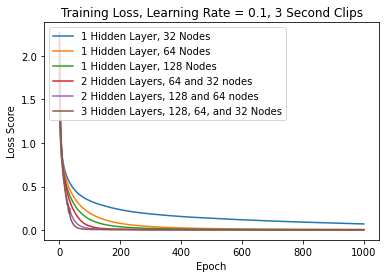

In [18]:
plot_loss(best_3_sec_experiments, f"Training Loss, Learning Rate = {best_3_sec_lr}, 3 Second Clips")

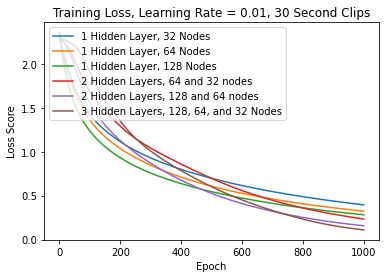

In [19]:
plot_loss(best_30_sec_experiments, f"Training Loss, Learning Rate = {best_30_sec_lr}, 30 Second Clips")

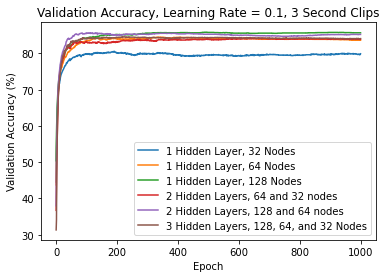

In [20]:
plot_validation_accuracies(best_3_sec_experiments, f"Validation Accuracy, Learning Rate = {best_3_sec_lr}, 3 Second Clips")

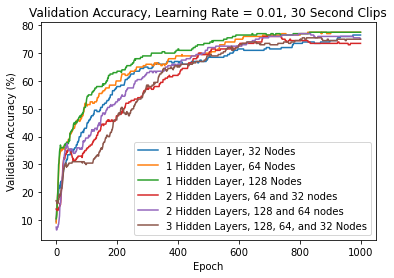

In [21]:
plot_validation_accuracies(best_30_sec_experiments, f"Validation Accuracy, Learning Rate = {best_30_sec_lr}, 30 Second Clips")

In [22]:
def get_accuracies(experiments, x_train, y_train, x_val, y_val, x_test, y_test):
    accuracies = {}
    for title, result in experiments.items():
        model = result["model"]
        train_acc, correct_by_training_classes = evaluate_model(model, x_train, y_train, batch_size=BATCH_SIZE)
        val_acc, correct_by_val_classes = evaluate_model(model, x_val, y_val, batch_size=BATCH_SIZE)
        test_acc, correct_by_test_classes = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE)
        accuracies[title] = {
            "train": train_acc,
            "val": val_acc,
            "test": test_acc,
            "class_scores_train": correct_by_training_classes,
            "class_scores_val": correct_by_val_classes,
            "class_scores_test": correct_by_test_classes
        }

    return accuracies

three_sec_accuracies = get_accuracies(best_3_sec_experiments, x_train=x_3_train, y_train=y_3_train, x_val=x_3_val, y_val=y_3_val, x_test=x_3_test, y_test=y_3_test)
thirty_sec_accuracies = get_accuracies(best_30_sec_experiments, x_train=x_30_train, y_train=y_30_train, x_val=x_30_val, y_val=y_30_val, x_test=x_30_test, y_test=y_30_test)

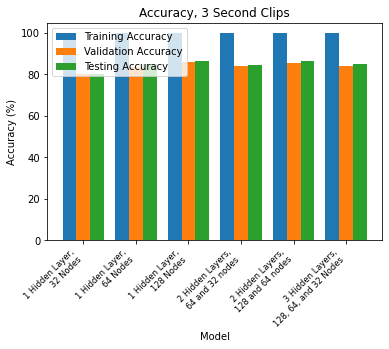

In [23]:
plot_accuracy_bar_chart(three_sec_accuracies, "Accuracy, 3 Second Clips")

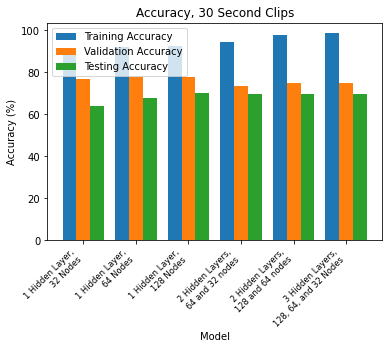

In [24]:
plot_accuracy_bar_chart(thirty_sec_accuracies, "Accuracy, 30 Second Clips")

In [25]:
def print_class_results(accuracy_results, title):

    train_accuracy = accuracy_results["train"]
    test_accuracy = accuracy_results["test"]
    val_accuracy = accuracy_results["val"]

    failed_count = {}
    for genre, correct_trained_counts in accuracy_results["class_scores_train"].items():
        failed_count[genre] = correct_trained_counts["total"] - correct_trained_counts["correct"]
    for genre, correct_val_counts in accuracy_results["class_scores_val"].items():
        failed_count[genre] += (correct_val_counts["total"] - correct_val_counts["correct"])
    for genre, correct_test_counts in accuracy_results["class_scores_test"].items():
        failed_count[genre] += (correct_test_counts["total"] - correct_test_counts["correct"])
        
    print_classifier_results(
        title=title,
        train_accuracy=train_accuracy,
        val_accuracy=val_accuracy,
        test_accuracy=test_accuracy,
        failed_count=failed_count
    )

In [26]:
for title, accuracy_obj in three_sec_accuracies.items():
    print_class_results(accuracy_obj, title)

1 Hidden Layer, 32 Nodes
Train accuracy: 98.08%
Train error:    1.92%
Train accuracy: 79.88%
Train error:    20.12%
Test accuracy:  80.03%
Test error:     19.97%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---     |      ---       |        ---         |
| 01  | ROCK       | 140            | 15.3%              |
| 02  | REGGAE     | 111            | 12.1%              |
| 03  | DISCO      | 108            | 11.8%              |
| 04  | POP        | 107            | 11.7%              |
| 05  | JAZZ       | 103            | 11.2%              |
| 06  | COUNTRY    | 102            | 11.1%              |
| 07  | HIPHOP     | 80             | 8.7%               |
| 08  | BLUES      | 76             | 8.3%               |
| 09  | METAL      | 54             | 5.9%               |
| 10  | CLASSICAL  | 35             | 3.8%               |
1 Hidden Layer, 64 Nodes
Train accuracy: 99.9%
Train error:    0.1%
Train accuracy: 83.63%
Train error:    16.37%
Test accuracy: 

In [27]:
for title, accuracy_obj in thirty_sec_accuracies.items():
    print_class_results(accuracy_obj, title)

1 Hidden Layer, 32 Nodes
Train accuracy: 88.17%
Train error:    11.83%
Train accuracy: 76.5%
Train error:    23.5%
Test accuracy:  64.0%
Test error:     36.0%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---     |      ---       |        ---         |
| 01  | DISCO      | 34             | 17.9%              |
| 02  | ROCK       | 31             | 16.3%              |
| 03  | BLUES      | 23             | 12.1%              |
| 04  | COUNTRY    | 23             | 12.1%              |
| 05  | HIPHOP     | 23             | 12.1%              |
| 06  | REGGAE     | 22             | 11.6%              |
| 07  | JAZZ       | 12             | 6.3%               |
| 08  | POP        | 10             | 5.3%               |
| 09  | METAL      | 9              | 4.7%               |
| 10  | CLASSICAL  | 3              | 1.6%               |
1 Hidden Layer, 64 Nodes
Train accuracy: 92.17%
Train error:    7.83%
Train accuracy: 77.5%
Train error:    22.5%
Test accuracy:  67

In [28]:
best_model_lr_3, best_model_name_3 = get_best_model(lr_experiment_dict_3_sec)
best_model_lr_30, best_model_name_30 = get_best_model(lr_experiment_dict_30_sec)

best_model_dict_3 = {best_model_name_3: lr_experiment_dict_3_sec[best_model_lr_3][best_model_name_3]}
best_model_dict_30 = {best_model_name_30: lr_experiment_dict_30_sec[best_model_lr_30][best_model_name_30]}

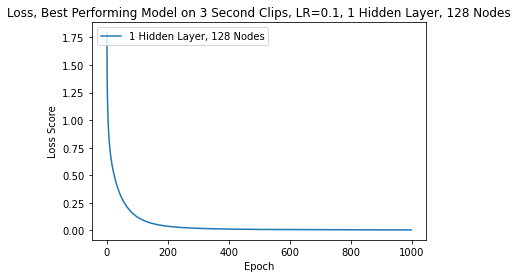

In [29]:
plot_loss(best_model_dict_3, f"Loss, Best Performing Model on 3 Second Clips, LR={best_model_lr_3}, {best_model_name_3}")

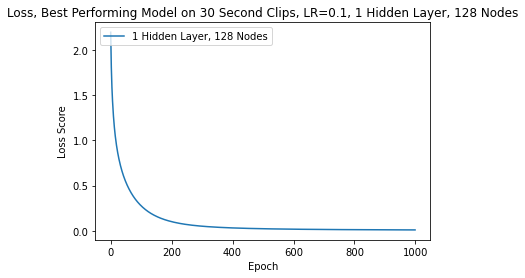

In [30]:
plot_loss(best_model_dict_30, f"Loss, Best Performing Model on 30 Second Clips, LR={best_model_lr_30}, {best_model_name_30}")

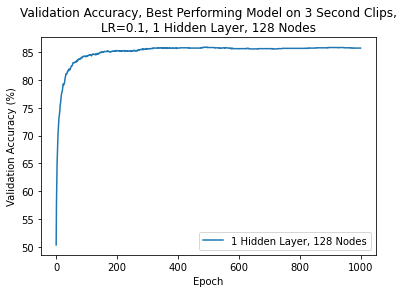

In [31]:
plot_validation_accuracies(best_model_dict_3, f"Validation Accuracy, Best Performing Model on 3 Second Clips,\nLR={best_model_lr_3}, {best_model_name_3}")

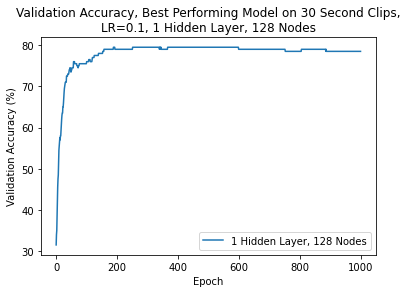

In [32]:
plot_validation_accuracies(best_model_dict_30, f"Validation Accuracy, Best Performing Model on 30 Second Clips,\nLR={best_model_lr_30}, {best_model_name_30}")

In [33]:
best_3_second_overall = get_accuracies(lr_experiment_dict_3_sec[best_model_lr_3], x_train=x_3_train, y_train=y_3_train, x_val=x_3_val, y_val=y_3_val, x_test=x_3_test, y_test=y_3_test)[best_model_name_3]
best_30_second_overall = get_accuracies(lr_experiment_dict_30_sec[best_model_lr_30], x_train=x_30_train, y_train=y_30_train, x_val=x_30_val, y_val=y_30_val, x_test=x_30_test, y_test=y_30_test)[best_model_name_30]

In [34]:
print_class_results(best_3_second_overall, best_model_name_3)

1 Hidden Layer, 128 Nodes
Train accuracy: 99.9%
Train error:    0.1%
Train accuracy: 85.69%
Train error:    14.31%
Test accuracy:  86.44%
Test error:     13.56%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---     |      ---       |        ---         |
| 01  | ROCK       | 112            | 19.9%              |
| 02  | COUNTRY    | 71             | 12.6%              |
| 03  | DISCO      | 66             | 11.7%              |
| 04  | REGGAE     | 63             | 11.2%              |
| 05  | JAZZ       | 59             | 10.5%              |
| 06  | HIPHOP     | 55             | 9.8%               |
| 07  | BLUES      | 45             | 8.0%               |
| 08  | POP        | 44             | 7.8%               |
| 09  | CLASSICAL  | 25             | 4.4%               |
| 10  | METAL      | 23             | 4.1%               |


In [35]:
print_class_results(best_30_second_overall, best_model_name_30)

1 Hidden Layer, 128 Nodes
Train accuracy: 99.83%
Train error:    0.17%
Train accuracy: 78.5%
Train error:    21.5%
Test accuracy:  71.0%
Test error:     29.0%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---     |      ---       |        ---         |
| 01  | HIPHOP     | 19             | 18.6%              |
| 02  | DISCO      | 15             | 14.7%              |
| 03  | COUNTRY    | 13             | 12.7%              |
| 04  | REGGAE     | 13             | 12.7%              |
| 05  | BLUES      | 12             | 11.8%              |
| 06  | ROCK       | 11             | 10.8%              |
| 07  | POP        | 7              | 6.9%               |
| 08  | JAZZ       | 6              | 5.9%               |
| 09  | METAL      | 4              | 3.9%               |
| 10  | CLASSICAL  | 2              | 2.0%               |


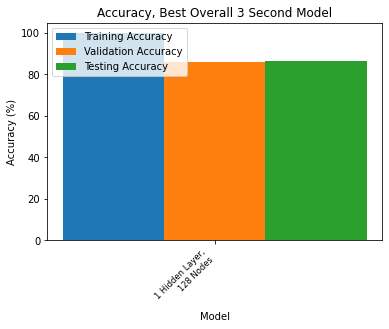

In [36]:
plot_accuracy_bar_chart({best_model_name_3: best_3_second_overall}, title=f"Accuracy, Best Overall 3 Second Model")

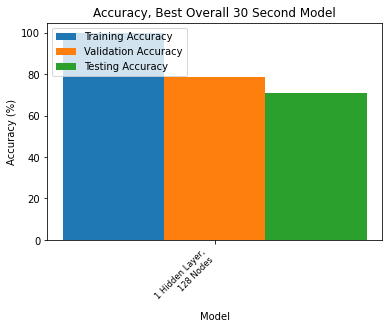

In [37]:
plot_accuracy_bar_chart({best_model_name_30: best_30_second_overall}, title=f"Accuracy, Best Overall 30 Second Model")